In [ ]:
#!pip install gitpython
import git
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer as IterativeImputer
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, log_loss, roc_auc_score, hamming_loss, fbeta_score, auc, roc_curve, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
plt.style.use('seaborn-colorblind')

<ipython-input-53-7403950b1eb9>:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


# Get Data

In [ ]:
def download_github_repository(repo_url, repository_name, destination_folder):
# the inputs include: repository location, repository name, and destination folder name.
    # check to see if there is afolder with the same name as repository there. if yes, ask if it should be replaced.
    if os.path.exists(repository_name):
        response = input(f"{repository_name} already exists in {destination_folder}. do you want to update its contents? (yes/no): ").strip().lower()
        if response == 'yes':
            try:
                shutil.rmtree(repository_name)  # Delete the existing folder and its contents
            except Exception as e:
                print(f"error deleting {repository_name} folder: {e}")
                return
        else:
            print(f"fine. i left {repository_name} alone.")
            return
    # clone repository to the destination folder
    try:
        git.Git(destination_folder).clone(repo_url)
        print(f"okay i just deleted the old file and downloaded {repository_name} again from github. it's in the {destination_folder} folder.")
    except git.exc.GitCommandError as e:
        print(f"i wasn't able to get {repository_name} from github: {e}")

In [ ]:
# specify the repository name and owner
github_account = "joel-day"
repository_name = "titanic"
repository_url = f"https://github.com/{github_account}/{repository_name}"
destination_folder = "/content"
download_github_repository(repository_url, repository_name, destination_folder)

titanic already exists in /content. do you want to update its contents? (yes/no): 
fine. i left titanic alone.


In [ ]:
# load the data into a pandas dataframe
file_location_within_repository = "train.csv"
titanic = pd.read_csv(f'/content/titanic/{file_location_within_repository}')
titanic.columns = titanic.columns.str.replace(' ', '_')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

In [ ]:
titanic.info()
titanic.describe()
titanic.isnull().sum()
titanic.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


(891, 12)

## Numerical

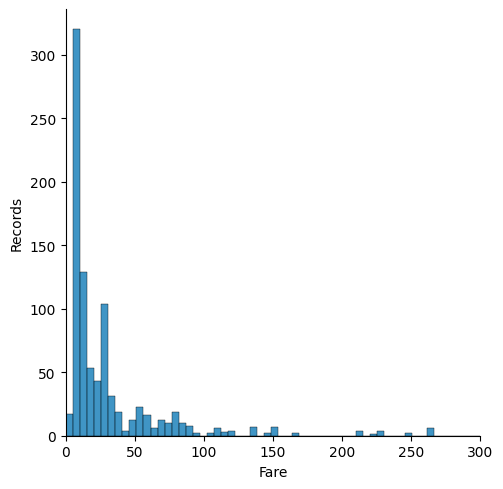

In [ ]:
# show distrobution
sns.displot(titanic['Fare'],bins=100,kde=False)
plt.xlim(0,300)
plt.xlabel('Fare')
plt.ylabel('Records')
plt.show()

## Categorical

In [ ]:
# show likelihood of survival
titanic[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


Text(0.5, 1.0, 'Age Distribution')

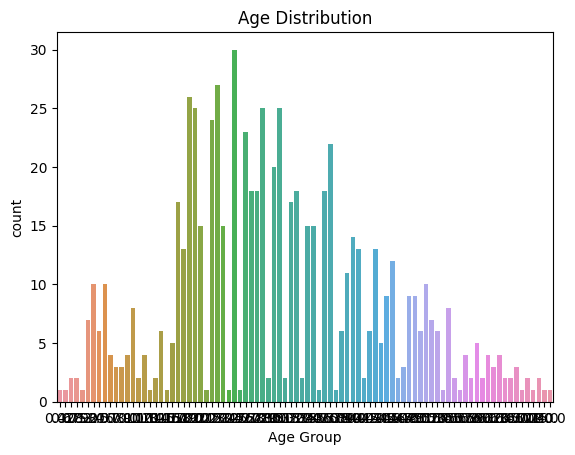

In [ ]:
# plot distrobutions
titanic['Age'].value_counts()
sns.countplot(x=titanic["Age"])
plt.xlabel('Age Group')
plt.title('Age Distribution')

## Numerical and Categorical

Text(0.5, 1.0, 'Sex Against Family Count')

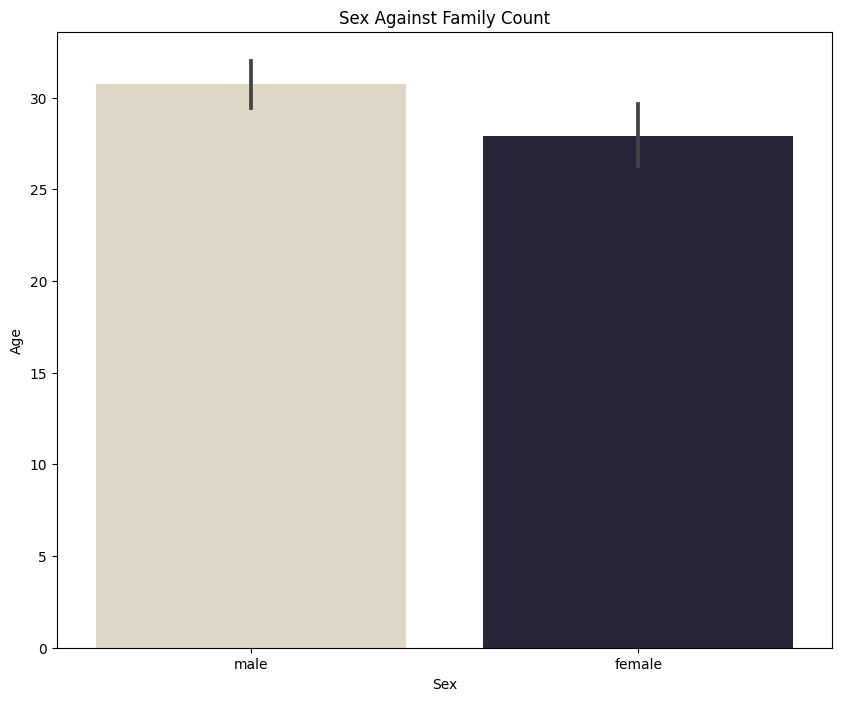

In [ ]:
# plot one numerical and one categorical
sns.barplot(data= titanic,x = 'Sex', y = 'Age', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(10, 8)
plt.title("Sex Against Family Count")

## Target

Text(0.5, 1.0, 'Suvival by Sex Against Age')

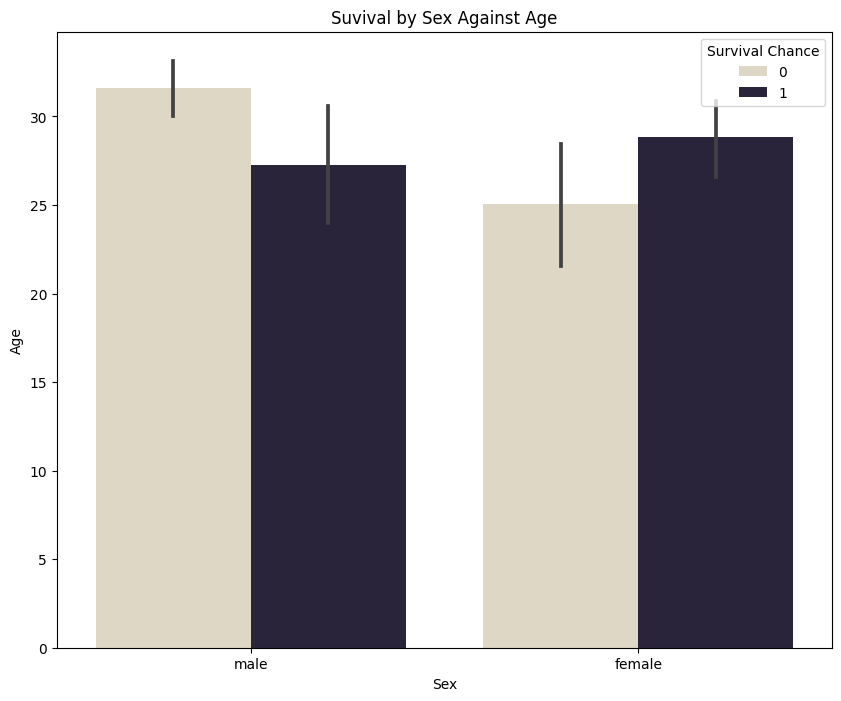

In [ ]:
# plot one numerical and one categorical against the target variable
sns.barplot(data= titanic,x = 'Sex', y = 'Age', hue = 'Survived', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(10, 8)
plt.xlabel('Sex')
plt.ylabel('Age')
plt.legend(loc='upper right', title = 'Survival Chance')
plt.title("Suvival by Sex Against Age")

Sex,female,male,All
Survived,,,
0,81,468,549
1,233,109,342
All,314,577,891


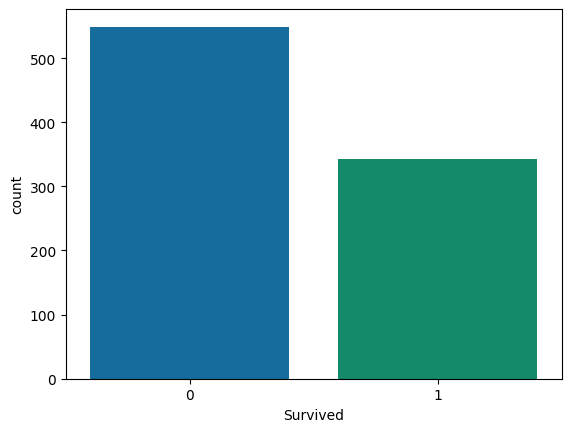

In [ ]:
# target varibale distrobution
sns.countplot(x=titanic['Survived'])

# contingency tables for any given feature
ct = pd.crosstab(titanic['Survived'], titanic['Sex'],margins=True)
ct

# Partition

In [ ]:
X = titanic.drop(columns='Survived')
y = titanic['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True)

#confirm that dataset has been partitioned correctly
print(titanic.shape)
print(X_train.shape)
print(X_test.shape)

(891, 12)
(623, 11)
(268, 11)


## Balance Target Variable

In [ ]:
y_train.value_counts()

0    389
1    234
Name: Survived, dtype: int64

### we use the following equation:

### x = [p(records)-rare]/(1-p), where p=0.50,

In [ ]:
#resampling of training data set
#to_resample=train.loc[train['Survived'] == 1] #isolate all records of Survived=1
#our_resample=to_resample.sample(n=150, replace=True) #sample w/ replacement
#train_rebal=pd.concat([train, our_resample]) #combine original training set w/ resampled records
#train_rebal['Survived'].value_counts()

# Mssing Values

In [ ]:
X_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            116
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          485
Embarked         1
dtype: int64

In [ ]:
# Inpute based on distrobution
X_train['Age']= X_train['Age'].fillna(X_train['Age'].median())
X_test['Age']= X_test['Age'].fillna(X_test['Age'].median())

# custom impute
X_train['Embarked']=X_train['Embarked'].fillna('S')
X_test['Embarked']=X_test['Embarked'].fillna('S')
# or just drop
X_train.drop('Cabin', axis=1, inplace=True)
X_test.drop('Cabin', axis=1, inplace=True)

In [ ]:
X_train.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

# Feature Transformations

## Numerical

In [ ]:
# binning numerical
X_train['Age_c'] = pd.cut(x=X_train['Age'], bins=[0, 3, 17, 63, 99],
                     labels=['Baby/Toddler', 'Child', 'Adult','Elderly'])
X_test['Age_c'] = pd.cut(x=X_test['Age'], bins=[0, 3, 17, 63, 99],
                     labels=['Baby/Toddler', 'Child', 'Adult','Elderly'])

# scale
X_train['Age_mm'] = MinMaxScaler().fit_transform(X_train[['Age']])

## Categorical

In [ ]:
#df['b'].replace(['male', 'female'],[0, 1], inplace=True)

In [ ]:
# dummy variables one feature at a time
sex_dummies = pd.get_dummies(X_train['Sex'], prefix = 'Sex', drop_first=False)
pclass_dummies = pd.get_dummies(X_train['Pclass'], prefix = 'Pclass', drop_first=False)
embarked_dummies = pd.get_dummies(X_train['Embarked'], prefix = 'Embarked', drop_first=False)
age_dummies = pd.get_dummies(X_train['Age_c'], prefix = 'Age', drop_first=False)

In [ ]:
sex_dummies_test = pd.get_dummies(X_test['Sex'], prefix = 'Sex', drop_first=False)
pclass_dummies_test = pd.get_dummies(X_test['Pclass'], prefix = 'Pclass', drop_first=False)
embarked_dummies_test = pd.get_dummies(X_test['Embarked'], prefix = 'Embarked', drop_first=False)
age_dummies_test = pd.get_dummies(X_test['Age_c'], prefix = 'Age', drop_first=False)